In [1]:
import random
import math
import numpy as np
import PIL
from PIL import Image
import matplotlib
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from numpy import array
from torch.distributions import Categorical

In [2]:
import random 
numprocess = 5
file_address = [] 
file_size = [] 
def get_fileAddress(id):
    #print(id)
    global file_address, file_size
    start_index = 0
    for i in range(id):
        start_index += file_size[i]
    start_Address = file_address[start_index-1]
    start_Address.append(file_size[id])
    return start_Address

def makefile(id,size):
    global file_address
    global file_size
    file_size.append(size)
    while(True):
        allotted_platter = random.randrange(1,14,1)
        allotted_track = random.randrange(1,10,1)
        allotted_sector = random.randrange(1,360,1)
        for i in range(size):
            if [allotted_platter,allotted_track,(allotted_sector+i)%360] in file_address:
                print('Contiguous memory couldn\'t be allocated. Trying again')
                continue
        for i in range(size):
            file_address.append([allotted_platter,allotted_track,(allotted_sector+i)%360])
        start_address = [allotted_platter,allotted_track, allotted_sector]
        print('Memory block allotted starting from', start_address, 'of size', size)
        break

def createFile():
    n = 50
    
    for i in range(n):
        makefile(i,random.randint(1,20))
    
    #for i in range(n):
        #print(get_fileAddress(i))
createFile()

Memory block allotted starting from [6, 5, 109] of size 18
Memory block allotted starting from [3, 2, 217] of size 5
Memory block allotted starting from [6, 5, 138] of size 9
Memory block allotted starting from [11, 4, 257] of size 7
Memory block allotted starting from [8, 7, 214] of size 11
Memory block allotted starting from [11, 6, 1] of size 12
Memory block allotted starting from [13, 6, 343] of size 10
Memory block allotted starting from [6, 5, 314] of size 9
Memory block allotted starting from [1, 2, 23] of size 3
Memory block allotted starting from [9, 1, 60] of size 4
Memory block allotted starting from [8, 9, 133] of size 10
Memory block allotted starting from [8, 2, 163] of size 7
Memory block allotted starting from [12, 4, 294] of size 12
Memory block allotted starting from [13, 5, 308] of size 1
Memory block allotted starting from [10, 7, 149] of size 9
Memory block allotted starting from [5, 7, 16] of size 3
Memory block allotted starting from [8, 7, 22] of size 18
Memory 

In [3]:
class disjointset:

    def __init__(self, n):
        self.n=n
        self.parent = list(range(n))
        self.rank = [0 for x in range(n)]
 
    def findset(self, v):
        if not v == self.parent[v]:
            self.parent[v] = self.findset(self.parent[v])
        return self.parent[v]
 
    def union(self, x, y):
        xRoot = self.findset(x)
        yRoot = self.findset(y)
        if xRoot == yRoot:
            return
        if self.rank[xRoot] > self.rank[yRoot]:
            self.parent[yRoot] = xRoot
        else:
            self.parent[xRoot] = yRoot
            if self.rank[xRoot] == self.rank[yRoot]:
                self.rank[yRoot] += 1
 
    def printParent(self):
        v=[0]*self.n
        s=[]
        while 0 in v:
            x=v.index(0)
            p=self.parent[x]
            v[x]=1
            l=[x]
            for i in range(self.n):
                if v[i]==0 and self.parent[i]==p:
                    v[i]=1
                    l.append(i)
            s.append(l)
        #print(s)
        return s

def dsu(u,v,s):

    e=[]
    x=[]
    x.append(u)
    x.append(v)
    e.append(x)
    s.union(e[0][0],e[0][1])

    


In [4]:
import time
class HardDiskDrive():
    # Returns time taken for read/write operations
    
    def __init__(self):
        self.tracktime = 100 # stores time needed to move between two adjacent tracks to read
        self.sectortime = 50 # stores time needed to move between two adjacent sectors to read
        self.readtime = 1
        self.writetime = 2
        self.curtrack = [1] * 14 # stores current track of read/write head of all 14 platters
        self.cursector = [1] * 14 # stores current sector of read/write head of all 14 platters

        
    def calculateTimeRead(self,physicalAddr):
        # Calculates time to read from the specified physical address
        time.sleep(1)
        #print(physicalAddr)
        # Find filesize given files list and file id
        filesize = physicalAddr[3]

        # Get platter, track and sector number
        platter = physicalAddr[0]
        track = physicalAddr[1]
        sector = physicalAddr[2]

        ttime = self.tracktime * abs( track - self.curtrack[platter-1] )  # Time taken for read/write head to move to the required track for the given platter
        stime = self.sectortime * (( sector - self.cursector[platter-1] ) % 360 )  # Time taken for read/write head to move to the required sector for the given platter
        etime = filesize * ( self.readtime + self.sectortime )  # Time taken for read/write head to move to different sectors to read

        totaltime = ttime + stime + etime  # Total time taken

        self.curtrack[platter-1] = track # Sets current track of platter to the track from physical address
        self.cursector[platter-1] = ( sector + filesize ) % 360  # Sets current sector of platter to sector the read/write head moves to after reading

        return totaltime

    def calculateTimeWrite(self,physicalAddr):
        # Calculates time to write to the specified physical address
        time.sleep(1)
        #print('physical address',physicalAddr)
        # Find filesize given files list and file id
        filesize = physicalAddr[3]

        # Get platter, track and sector number
        platter = physicalAddr[0]
        track = physicalAddr[1]
        sector = physicalAddr[2]

        ttime = self.tracktime * abs( track - self.curtrack[platter-1] ) # Time taken for read/write head to move to the required track for the given platter
        stime = self.sectortime * (( sector - self.cursector[platter-1] ) % 360 ) # Time taken for read/write head to move to the required sector for the given platter
        etime = filesize * ( self.writetime + self.sectortime ) # Time taken for read/write head to move to different sectors to read

        totaltime = ttime + stime + etime # Total time taken

        self.curtrack[platter-1] = track  # Sets current track of platter to the track from physical address
        self.cursector[platter-1] = ( sector + filesize ) % 360  # Sets current sector of platter to sector the read/write head moves to after reading

        return totaltime


In [5]:
class Process: 
    def get_request(self):
        
        request_type = random.randint(0,1) #0 - read, 1 - write
        amount = random.uniform(1,1000)
        file_no=0
        if request_type == 0:
            file_no = random.randint(1,49)
        else:
            file_no =random.randint(0,49)
        return [request_type,amount,file_no] 

In [6]:
def get_faddress(id):
    return [3,4,100,5]

In [7]:
#Environment
class Devices:
    def __init__(self):
        self.p1= Process()
        self.p2= Process()
        self.p3= Process()
        self.p4= Process()
        self.p5= Process()
        self.devices = [self.p1,self.p2,self.p3,self.p4,self.p5]
    
    def Generate_Requests(self):      
        request_buffer = []
        for i in self.devices:
            x = i.get_request()
            #print(x)
            x[2] = get_fileAddress(x[2])
            if x!=None:
                request_buffer.append(x)

        return request_buffer

In [8]:
class Buffer:
    def __init__(self):
        dev = Devices()
        self.buff = dev.Generate_Requests()
        #print('ewfew',self.buff)
        self.i=0
        self.j=0
        self.size = len(self.buff)
        self.store_actions=[]
        #print('size',self.size)
    def request_disk(self):
        
        s=disjointset(numprocess)

        for i in range(int((numprocess*(numprocess-1))/2)):
            if self.store_actions[i]==1:
                k = int(i/self.size)
                j = int(i%self.size)
                #print('k','j',k,j)
                dsu(k,j,s)
                
        merge_buffer = s.printParent()
        print("After merging",merge_buffer)
        
        #print(merge_buffer)
        
        #print(self.buff)
        
        hdd1 = HardDiskDrive()
        hdd2 = HardDiskDrive()
        timedelay = 10
        time1 = 0
        responsetime=0
        #print(merge_buffer)
        for i in range(len(merge_buffer)):
            x=0
            for j in range(len(merge_buffer[i])):
                #print(merge_buffer[i][j])
                if self.buff[merge_buffer[i][j]][0]==0:
                    x = x + hdd1.calculateTimeRead(self.buff[merge_buffer[i][j]][2])
                elif self.buff[merge_buffer[i][j]][0]==1:
                    x = x + hdd1.calculateTimeWrite(self.buff[merge_buffer[i][j]][2])
            responsetime+=x*len(merge_buffer[i])
            
            time1 += x #+ timedelay
            
        time2 = 0
        for i in range(len(self.buff)):
            if self.buff[i][0]==0:
                    time2 = time2 + hdd2.calculateTimeRead(self.buff[i][2])
            elif self.buff[i][0]==1:
                time2 = time2 + hdd2.calculateTimeWrite(self.buff[i][2])
            time2 = time2 + timedelay
            
        time = time2 - time1
        ans = time1/responsetime
        print('time',time1,time1/responsetime)          
        if ans>0.21:
            ans=1
        else:
            ans=-1
        
        return ans

    def getRequest(self,action):
        self.store_actions.append(action)
        if self.i==self.size-1 and self.j == self.size-1:
            #print('yes')
            time_taken = self.request_disk()
            return _,time_taken
        req1 = self.buff[self.i]
        req2 = 0
        
        if self.j< self.size-1:
            req2 = self.buff[self.j]
            self.j+=1
        else:
            self.i+=1
            self.j=0
            req1 = self.buff[self.i]
            req2 = self.buff[self.j]
        '''x = random.randint(1,14)
        y = random.randint(1,10)
        z = random.randint(1,360)
        a = random.randint(1,14)
        b = random.randint(1,10)
        c = random.randint(1,360)'''
        #print(req1,req2)
        return [req1[0],req1[1],req1[2],req2[0],req2[1],req2[2]],0
    

In [9]:

class environment:
    def __init__(self):
        self.counter = 0
        self.b = None
    def reset(self):
        self.b = Buffer()
        self.counter = 0
        self.counter += 1
        a,reward = self.b.getRequest(0)
        state = [a[0],a[2][0]/14,a[2][1]/10,a[2][2]/360,a[3],a[5][0]/14,a[5][1]/10,a[5][2]/360]
        done = False
        state = array(state)
        return state,reward,done,_ 
    def step(self,action):
        #b = Buffer()
        self.counter+=1
        a,reward = self.b.getRequest(action)
        #print("a",a)
        if self.counter >=(numprocess*(numprocess)):
            done = True
            return array([0,0,0,0,0,0,0,0]),reward,done,_ 
        state = [a[0],a[2][0]/14,a[2][1]/10,a[2][2]/360,a[3],a[5][0]/14,a[5][1]/10,a[5][2]/360]
        done = False
        
        state = array(state)
        return state,reward,done,_ 

In [10]:
class model(nn.Module):
    def __init__(self):
        super(model,self).__init__()

        self.fc1 = nn.Linear(8,16)
        self.fc2 = nn.Linear(16,32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self,x):
        
        x=x.reshape(x.shape[0],1,8)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        return F.softmax(self.fc3(x.contiguous().view(x.size(0), -1)),dim=1)
        

In [11]:
policy=model()
optimizer = optim.RMSprop(policy.parameters())
gamma = 0.99
#env = gym.make('CartPole-v0').unwrapped

In [12]:
env = environment()
lis=[]

In [13]:
def PolicyGradient(numepisodes):
    global lis
    rew =0 
    max_reward = 0
    for i in range(numepisodes):
        states = []     #List to store the states
        actions = []    #List to store the actions
        rewards = []    #List to store the rewards
        done = False
        state = env.reset()
        steps = 0
        states.append(state[0])
        rr=0
        while done != True and steps<1500:
            steps+=1
            
            if len(state)==8:
                put = state
            else:
                put = state[0]
            inp = torch.from_numpy(put).unsqueeze(0)
            inp= inp.type('torch.FloatTensor')
            act = policy(inp)
            m = Categorical(act)
            action = m.sample()
            state,reward,done,_=env.step(int(action.item()))
            #print(reward)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            rew+=reward
            rr+=reward
        max_reward = max(max_reward,rr)
        optimizer.zero_grad()
        loss_sum =0
        rewards[-1] = -1
        cum_reward =0
        
        # Calculate the expected rewards
        for j in range(steps-1,0,-1):
            if rewards[j]!=0:
                cum_reward = cum_reward*gamma + rewards[j]
                rewards[j]=cum_reward
                
        #Normalize the rewards     
        rewards_mean = np.mean(rewards)
        rewards_std = np.std(rewards)
        for j in range(steps):
            rewards[j] = (rewards[j] - rewards_mean) / rewards_std
        for j in range(steps):
            inp = torch.from_numpy(states[j]).unsqueeze(0)
            inp = inp.type('torch.FloatTensor')
            acts = policy(inp)
            print("actions",acts)
            m = Categorical(acts)
            loss = -m.log_prob(actions[j]) * rewards[j]
            loss.backward()
            loss_sum+=loss
        optimizer.step()
        if i % 10 == 0 and i!=0:            
            print("Episode ",i,rew/10)
            lis.append(rew/10)
            rew =0

In [14]:
PolicyGradient(200)

After merging [[0, 1, 2, 3, 4]]
time 43074 0.2
actions tensor([[ 0.5103,  0.4897]])
actions tensor([[ 0.5168,  0.4832]])
actions tensor([[ 0.5162,  0.4838]])
actions tensor([[ 0.5123,  0.4877]])
actions tensor([[ 0.4963,  0.5037]])
actions tensor([[ 0.4963,  0.5037]])
actions tensor([[ 0.5034,  0.4966]])
actions tensor([[ 0.5073,  0.4927]])
actions tensor([[ 0.5010,  0.4990]])
actions tensor([[ 0.5046,  0.4954]])
actions tensor([[ 0.5046,  0.4954]])
actions tensor([[ 0.5068,  0.4932]])
actions tensor([[ 0.5120,  0.4880]])
actions tensor([[ 0.5071,  0.4929]])
actions tensor([[ 0.5050,  0.4950]])
actions tensor([[ 0.5050,  0.4950]])
actions tensor([[ 0.5096,  0.4904]])
actions tensor([[ 0.5129,  0.4871]])
actions tensor([[ 0.5074,  0.4926]])
actions tensor([[ 0.4985,  0.5015]])
actions tensor([[ 0.4985,  0.5015]])
actions tensor([[ 0.4986,  0.5014]])
actions tensor([[ 0.5038,  0.4962]])
actions tensor([[ 0.5018,  0.4982]])
After merging [[0, 1, 2, 3, 4]]
time 51330 0.2
actions tensor([[ 

time 27269 0.34255816290638663
actions tensor([[ 0.3606,  0.6394]])
actions tensor([[ 0.3629,  0.6371]])
actions tensor([[ 0.3619,  0.6381]])
actions tensor([[ 0.3733,  0.6267]])
actions tensor([[ 0.3559,  0.6441]])
actions tensor([[ 0.3559,  0.6441]])
actions tensor([[ 0.3601,  0.6399]])
actions tensor([[ 0.3583,  0.6417]])
actions tensor([[ 0.3705,  0.6295]])
actions tensor([[ 0.3512,  0.6488]])
actions tensor([[ 0.3512,  0.6488]])
actions tensor([[ 0.3539,  0.6461]])
actions tensor([[ 0.3537,  0.6463]])
actions tensor([[ 0.3631,  0.6369]])
actions tensor([[ 0.3603,  0.6397]])
actions tensor([[ 0.3603,  0.6397]])
actions tensor([[ 0.3666,  0.6334]])
actions tensor([[ 0.3649,  0.6351]])
actions tensor([[ 0.3716,  0.6284]])
actions tensor([[ 0.3554,  0.6446]])
actions tensor([[ 0.3554,  0.6446]])
actions tensor([[ 0.3585,  0.6415]])
actions tensor([[ 0.3590,  0.6410]])
actions tensor([[ 0.3680,  0.6320]])
After merging [[0, 1, 2, 3, 4]]
time 38971 0.2
actions tensor([[ 0.2430,  0.7570]

time 38910 0.2
actions tensor([[ 0.4344,  0.5656]])
actions tensor([[ 0.4348,  0.5652]])
actions tensor([[ 0.4267,  0.5733]])
actions tensor([[ 0.4230,  0.5770]])
actions tensor([[ 0.4380,  0.5620]])
actions tensor([[ 0.4380,  0.5620]])
actions tensor([[ 0.4396,  0.5604]])
actions tensor([[ 0.4320,  0.5680]])
actions tensor([[ 0.4293,  0.5707]])
actions tensor([[ 0.4195,  0.5805]])
actions tensor([[ 0.4195,  0.5805]])
actions tensor([[ 0.4238,  0.5762]])
actions tensor([[ 0.4176,  0.5824]])
actions tensor([[ 0.4127,  0.5873]])
actions tensor([[ 0.4257,  0.5743]])
actions tensor([[ 0.4257,  0.5743]])
actions tensor([[ 0.4295,  0.5705]])
actions tensor([[ 0.4237,  0.5763]])
actions tensor([[ 0.4195,  0.5805]])
actions tensor([[ 0.4345,  0.5655]])
actions tensor([[ 0.4345,  0.5655]])
actions tensor([[ 0.4363,  0.5637]])
actions tensor([[ 0.4287,  0.5713]])
actions tensor([[ 0.4235,  0.5765]])
After merging [[0, 1, 3, 4], [2]]
time 49626 0.2787570354891982
actions tensor([[ 0.3324,  0.6676

time 45732 0.30415610846186075
actions tensor([[ 0.3892,  0.6108]])
actions tensor([[ 0.3888,  0.6112]])
actions tensor([[ 0.3921,  0.6079]])
actions tensor([[ 0.3933,  0.6067]])
actions tensor([[ 0.3895,  0.6105]])
actions tensor([[ 0.3895,  0.6105]])
actions tensor([[ 0.3892,  0.6108]])
actions tensor([[ 0.3917,  0.6083]])
actions tensor([[ 0.3931,  0.6069]])
actions tensor([[ 0.3866,  0.6134]])
actions tensor([[ 0.3866,  0.6134]])
actions tensor([[ 0.3886,  0.6114]])
actions tensor([[ 0.3884,  0.6116]])
actions tensor([[ 0.3913,  0.6087]])
actions tensor([[ 0.3885,  0.6115]])
actions tensor([[ 0.3885,  0.6115]])
actions tensor([[ 0.3879,  0.6121]])
actions tensor([[ 0.3906,  0.6094]])
actions tensor([[ 0.3925,  0.6075]])
actions tensor([[ 0.3891,  0.6109]])
actions tensor([[ 0.3891,  0.6109]])
actions tensor([[ 0.3877,  0.6123]])
actions tensor([[ 0.3912,  0.6088]])
actions tensor([[ 0.3926,  0.6074]])
After merging [[0, 1, 2, 3], [4]]
time 54195 0.2796785979687887
actions tensor([[

time 49715 0.2
actions tensor([[ 0.4918,  0.5082]])
actions tensor([[ 0.4877,  0.5123]])
actions tensor([[ 0.4819,  0.5181]])
actions tensor([[ 0.4806,  0.5194]])
actions tensor([[ 0.4904,  0.5096]])
actions tensor([[ 0.4904,  0.5096]])
actions tensor([[ 0.4873,  0.5127]])
actions tensor([[ 0.4817,  0.5183]])
actions tensor([[ 0.4820,  0.5180]])
actions tensor([[ 0.4925,  0.5075]])
actions tensor([[ 0.4925,  0.5075]])
actions tensor([[ 0.4895,  0.5105]])
actions tensor([[ 0.4862,  0.5138]])
actions tensor([[ 0.4854,  0.5146]])
actions tensor([[ 0.4983,  0.5017]])
actions tensor([[ 0.4983,  0.5017]])
actions tensor([[ 0.4952,  0.5048]])
actions tensor([[ 0.4917,  0.5083]])
actions tensor([[ 0.4858,  0.5142]])
actions tensor([[ 0.4996,  0.5004]])
actions tensor([[ 0.4996,  0.5004]])
actions tensor([[ 0.4970,  0.5030]])
actions tensor([[ 0.4936,  0.5064]])
actions tensor([[ 0.4876,  0.5124]])
After merging [[0, 1, 2, 3], [4]]
time 63109 0.29949505974809937
actions tensor([[ 0.5112,  0.488

time 58227 0.2
actions tensor([[ 0.5007,  0.4993]])
actions tensor([[ 0.5106,  0.4894]])
actions tensor([[ 0.5018,  0.4982]])
actions tensor([[ 0.5066,  0.4934]])
actions tensor([[ 0.4986,  0.5014]])
actions tensor([[ 0.4986,  0.5014]])
actions tensor([[ 0.5097,  0.4903]])
actions tensor([[ 0.5013,  0.4987]])
actions tensor([[ 0.5060,  0.4940]])
actions tensor([[ 0.5041,  0.4959]])
actions tensor([[ 0.5041,  0.4959]])
actions tensor([[ 0.5146,  0.4854]])
actions tensor([[ 0.5052,  0.4948]])
actions tensor([[ 0.5101,  0.4899]])
actions tensor([[ 0.4998,  0.5002]])
actions tensor([[ 0.4998,  0.5002]])
actions tensor([[ 0.5092,  0.4908]])
actions tensor([[ 0.5002,  0.4998]])
actions tensor([[ 0.5052,  0.4948]])
actions tensor([[ 0.4986,  0.5014]])
actions tensor([[ 0.4986,  0.5014]])
actions tensor([[ 0.5097,  0.4903]])
actions tensor([[ 0.5013,  0.4987]])
actions tensor([[ 0.5060,  0.4940]])
After merging [[0], [1, 3], [2], [4]]
time 30082 0.7505489021956088
actions tensor([[ 0.5214,  0.

time 45390 0.2
actions tensor([[ 0.4878,  0.5122]])
actions tensor([[ 0.4888,  0.5112]])
actions tensor([[ 0.4879,  0.5121]])
actions tensor([[ 0.4894,  0.5106]])
actions tensor([[ 0.4873,  0.5127]])
actions tensor([[ 0.4873,  0.5127]])
actions tensor([[ 0.4888,  0.5112]])
actions tensor([[ 0.4877,  0.5123]])
actions tensor([[ 0.4894,  0.5106]])
actions tensor([[ 0.4876,  0.5124]])
actions tensor([[ 0.4876,  0.5124]])
actions tensor([[ 0.4883,  0.5117]])
actions tensor([[ 0.4880,  0.5120]])
actions tensor([[ 0.4889,  0.5111]])
actions tensor([[ 0.4878,  0.5122]])
actions tensor([[ 0.4878,  0.5122]])
actions tensor([[ 0.4895,  0.5105]])
actions tensor([[ 0.4879,  0.5121]])
actions tensor([[ 0.4893,  0.5107]])
actions tensor([[ 0.4876,  0.5124]])
actions tensor([[ 0.4876,  0.5124]])
actions tensor([[ 0.4889,  0.5111]])
actions tensor([[ 0.4879,  0.5121]])
actions tensor([[ 0.4895,  0.5105]])
After merging [[0, 1, 3], [2], [4]]
time 47835 0.5108339295821275
actions tensor([[ 0.4764,  0.52

time 49555 0.2
actions tensor([[ 0.5578,  0.4422]])
actions tensor([[ 0.5677,  0.4323]])
actions tensor([[ 0.5592,  0.4408]])
actions tensor([[ 0.5708,  0.4292]])
actions tensor([[ 0.5530,  0.4470]])
actions tensor([[ 0.5530,  0.4470]])
actions tensor([[ 0.5623,  0.4377]])
actions tensor([[ 0.5543,  0.4457]])
actions tensor([[ 0.5654,  0.4346]])
actions tensor([[ 0.5558,  0.4442]])
actions tensor([[ 0.5558,  0.4442]])
actions tensor([[ 0.5659,  0.4341]])
actions tensor([[ 0.5572,  0.4428]])
actions tensor([[ 0.5688,  0.4312]])
actions tensor([[ 0.5566,  0.4434]])
actions tensor([[ 0.5566,  0.4434]])
actions tensor([[ 0.5660,  0.4340]])
actions tensor([[ 0.5578,  0.4422]])
actions tensor([[ 0.5691,  0.4309]])
actions tensor([[ 0.5537,  0.4463]])
actions tensor([[ 0.5537,  0.4463]])
actions tensor([[ 0.5632,  0.4368]])
actions tensor([[ 0.5550,  0.4450]])
actions tensor([[ 0.5662,  0.4338]])
After merging [[0, 1, 2, 3, 4]]
time 46436 0.2
actions tensor([[ 0.5879,  0.4121]])
actions tenso

time 59193 0.31146014206787687
actions tensor([[ 0.5323,  0.4677]])
actions tensor([[ 0.5323,  0.4677]])
actions tensor([[ 0.5343,  0.4657]])
actions tensor([[ 0.5358,  0.4642]])
actions tensor([[ 0.5326,  0.4674]])
actions tensor([[ 0.5326,  0.4674]])
actions tensor([[ 0.5325,  0.4675]])
actions tensor([[ 0.5343,  0.4657]])
actions tensor([[ 0.5357,  0.4643]])
actions tensor([[ 0.5326,  0.4674]])
actions tensor([[ 0.5326,  0.4674]])
actions tensor([[ 0.5325,  0.4675]])
actions tensor([[ 0.5333,  0.4667]])
actions tensor([[ 0.5347,  0.4653]])
actions tensor([[ 0.5322,  0.4678]])
actions tensor([[ 0.5322,  0.4678]])
actions tensor([[ 0.5325,  0.4675]])
actions tensor([[ 0.5357,  0.4643]])
actions tensor([[ 0.5371,  0.4629]])
actions tensor([[ 0.5324,  0.4676]])
actions tensor([[ 0.5324,  0.4676]])
actions tensor([[ 0.5324,  0.4676]])
actions tensor([[ 0.5336,  0.4664]])
actions tensor([[ 0.5348,  0.4652]])
After merging [[0, 1, 2], [3], [4]]
time 69950 0.45307338558196775
actions tensor

time 37728 0.49805940594059406
actions tensor([[ 0.5353,  0.4647]])
actions tensor([[ 0.5352,  0.4648]])
actions tensor([[ 0.5368,  0.4632]])
actions tensor([[ 0.5379,  0.4621]])
actions tensor([[ 0.5357,  0.4643]])
actions tensor([[ 0.5357,  0.4643]])
actions tensor([[ 0.5362,  0.4638]])
actions tensor([[ 0.5365,  0.4635]])
actions tensor([[ 0.5373,  0.4627]])
actions tensor([[ 0.5357,  0.4643]])
actions tensor([[ 0.5357,  0.4643]])
actions tensor([[ 0.5357,  0.4643]])
actions tensor([[ 0.5361,  0.4639]])
actions tensor([[ 0.5366,  0.4634]])
actions tensor([[ 0.5346,  0.4654]])
actions tensor([[ 0.5346,  0.4654]])
actions tensor([[ 0.5342,  0.4658]])
actions tensor([[ 0.5370,  0.4630]])
actions tensor([[ 0.5383,  0.4617]])
actions tensor([[ 0.5343,  0.4657]])
actions tensor([[ 0.5343,  0.4657]])
actions tensor([[ 0.5347,  0.4653]])
actions tensor([[ 0.5369,  0.4631]])
actions tensor([[ 0.5381,  0.4619]])
After merging [[0, 1, 3, 4], [2]]
time 54982 0.30056962924898595
actions tensor([

time 40575 0.2922112995570919
actions tensor([[ 0.5426,  0.4574]])
actions tensor([[ 0.5533,  0.4467]])
actions tensor([[ 0.5516,  0.4484]])
actions tensor([[ 0.5422,  0.4578]])
actions tensor([[ 0.5417,  0.4583]])
actions tensor([[ 0.5417,  0.4583]])
actions tensor([[ 0.5546,  0.4454]])
actions tensor([[ 0.5530,  0.4470]])
actions tensor([[ 0.5410,  0.4590]])
actions tensor([[ 0.5418,  0.4582]])
actions tensor([[ 0.5418,  0.4582]])
actions tensor([[ 0.5556,  0.4444]])
actions tensor([[ 0.5541,  0.4459]])
actions tensor([[ 0.5410,  0.4590]])
actions tensor([[ 0.5423,  0.4577]])
actions tensor([[ 0.5423,  0.4577]])
actions tensor([[ 0.5548,  0.4452]])
actions tensor([[ 0.5532,  0.4468]])
actions tensor([[ 0.5419,  0.4581]])
actions tensor([[ 0.5436,  0.4564]])
actions tensor([[ 0.5436,  0.4564]])
actions tensor([[ 0.5573,  0.4427]])
actions tensor([[ 0.5558,  0.4442]])
actions tensor([[ 0.5426,  0.4574]])
Episode  90 0.4
After merging [[0, 1, 3, 4], [2]]
time 55473 0.31059562602882385
a

time 44410 0.2746274194545792
actions tensor([[ 0.5644,  0.4356]])
actions tensor([[ 0.5586,  0.4414]])
actions tensor([[ 0.5563,  0.4437]])
actions tensor([[ 0.5650,  0.4350]])
actions tensor([[ 0.5627,  0.4373]])
actions tensor([[ 0.5627,  0.4373]])
actions tensor([[ 0.5575,  0.4425]])
actions tensor([[ 0.5534,  0.4466]])
actions tensor([[ 0.5633,  0.4367]])
actions tensor([[ 0.5648,  0.4352]])
actions tensor([[ 0.5648,  0.4352]])
actions tensor([[ 0.5581,  0.4419]])
actions tensor([[ 0.5589,  0.4411]])
actions tensor([[ 0.5651,  0.4349]])
actions tensor([[ 0.5628,  0.4372]])
actions tensor([[ 0.5628,  0.4372]])
actions tensor([[ 0.5567,  0.4433]])
actions tensor([[ 0.5570,  0.4430]])
actions tensor([[ 0.5636,  0.4364]])
actions tensor([[ 0.5625,  0.4375]])
actions tensor([[ 0.5625,  0.4375]])
actions tensor([[ 0.5577,  0.4423]])
actions tensor([[ 0.5556,  0.4444]])
actions tensor([[ 0.5634,  0.4366]])
After merging [[0, 3], [1], [2], [4]]
time 27909 0.7301433654248639
actions tensor

time 20692 0.50517578125
actions tensor([[ 0.5537,  0.4463]])
actions tensor([[ 0.5562,  0.4438]])
actions tensor([[ 0.5543,  0.4457]])
actions tensor([[ 0.5554,  0.4446]])
actions tensor([[ 0.5549,  0.4451]])
actions tensor([[ 0.5549,  0.4451]])
actions tensor([[ 0.5567,  0.4433]])
actions tensor([[ 0.5561,  0.4439]])
actions tensor([[ 0.5568,  0.4432]])
actions tensor([[ 0.5558,  0.4442]])
actions tensor([[ 0.5558,  0.4442]])
actions tensor([[ 0.5582,  0.4418]])
actions tensor([[ 0.5572,  0.4428]])
actions tensor([[ 0.5577,  0.4423]])
actions tensor([[ 0.5572,  0.4428]])
actions tensor([[ 0.5572,  0.4428]])
actions tensor([[ 0.5595,  0.4405]])
actions tensor([[ 0.5584,  0.4416]])
actions tensor([[ 0.5586,  0.4414]])
actions tensor([[ 0.5539,  0.4461]])
actions tensor([[ 0.5539,  0.4461]])
actions tensor([[ 0.5555,  0.4445]])
actions tensor([[ 0.5542,  0.4458]])
actions tensor([[ 0.5552,  0.4448]])
After merging [[0, 1, 2, 3], [4]]
time 47771 0.33357307450597024
actions tensor([[ 0.55

time 36695 0.5384683111508944
actions tensor([[ 0.5653,  0.4347]])
actions tensor([[ 0.5615,  0.4385]])
actions tensor([[ 0.5650,  0.4350]])
actions tensor([[ 0.5631,  0.4369]])
actions tensor([[ 0.5587,  0.4413]])
actions tensor([[ 0.5587,  0.4413]])
actions tensor([[ 0.5595,  0.4405]])
actions tensor([[ 0.5579,  0.4421]])
actions tensor([[ 0.5587,  0.4413]])
actions tensor([[ 0.5649,  0.4351]])
actions tensor([[ 0.5649,  0.4351]])
actions tensor([[ 0.5609,  0.4391]])
actions tensor([[ 0.5645,  0.4355]])
actions tensor([[ 0.5625,  0.4375]])
actions tensor([[ 0.5594,  0.4406]])
actions tensor([[ 0.5594,  0.4406]])
actions tensor([[ 0.5585,  0.4415]])
actions tensor([[ 0.5589,  0.4411]])
actions tensor([[ 0.5580,  0.4420]])
actions tensor([[ 0.5622,  0.4378]])
actions tensor([[ 0.5622,  0.4378]])
actions tensor([[ 0.5583,  0.4417]])
actions tensor([[ 0.5619,  0.4381]])
actions tensor([[ 0.5598,  0.4402]])
After merging [[0, 1, 2, 4], [3]]
time 40511 0.2571604499403296
actions tensor([[ 

time 25291 0.7893816910640157
actions tensor([[ 0.5934,  0.4066]])
actions tensor([[ 0.5913,  0.4087]])
actions tensor([[ 0.5953,  0.4047]])
actions tensor([[ 0.5897,  0.4103]])
actions tensor([[ 0.6027,  0.3973]])
actions tensor([[ 0.6027,  0.3973]])
actions tensor([[ 0.6005,  0.3995]])
actions tensor([[ 0.6039,  0.3961]])
actions tensor([[ 0.5985,  0.4015]])
actions tensor([[ 0.5943,  0.4057]])
actions tensor([[ 0.5943,  0.4057]])
actions tensor([[ 0.5919,  0.4081]])
actions tensor([[ 0.5973,  0.4027]])
actions tensor([[ 0.5913,  0.4087]])
actions tensor([[ 0.5929,  0.4071]])
actions tensor([[ 0.5929,  0.4071]])
actions tensor([[ 0.5902,  0.4098]])
actions tensor([[ 0.5967,  0.4033]])
actions tensor([[ 0.5910,  0.4090]])
actions tensor([[ 0.6032,  0.3968]])
actions tensor([[ 0.6032,  0.3968]])
actions tensor([[ 0.6010,  0.3990]])
actions tensor([[ 0.6046,  0.3954]])
actions tensor([[ 0.5991,  0.4009]])
After merging [[0, 1, 3], [2], [4]]
time 45988 0.5256973022405121
actions tensor([

time 46386 0.43563928698886156
actions tensor([[ 0.5957,  0.4043]])
actions tensor([[ 0.5955,  0.4045]])
actions tensor([[ 0.5922,  0.4078]])
actions tensor([[ 0.5959,  0.4041]])
actions tensor([[ 0.5971,  0.4029]])
actions tensor([[ 0.5971,  0.4029]])
actions tensor([[ 0.5976,  0.4024]])
actions tensor([[ 0.5944,  0.4056]])
actions tensor([[ 0.5978,  0.4022]])
actions tensor([[ 0.5960,  0.4040]])
actions tensor([[ 0.5960,  0.4040]])
actions tensor([[ 0.5945,  0.4055]])
actions tensor([[ 0.5890,  0.4110]])
actions tensor([[ 0.5948,  0.4052]])
actions tensor([[ 0.5933,  0.4067]])
actions tensor([[ 0.5933,  0.4067]])
actions tensor([[ 0.5915,  0.4085]])
actions tensor([[ 0.5857,  0.4143]])
actions tensor([[ 0.5920,  0.4080]])
actions tensor([[ 0.5963,  0.4037]])
actions tensor([[ 0.5963,  0.4037]])
actions tensor([[ 0.5954,  0.4046]])
actions tensor([[ 0.5899,  0.4101]])
actions tensor([[ 0.5957,  0.4043]])
After merging [[0, 2, 4], [1], [3]]
time 46607 0.4601933311610731
actions tensor(

time 40938 0.49932915375795867
actions tensor([[ 0.5960,  0.4040]])
actions tensor([[ 0.5946,  0.4054]])
actions tensor([[ 0.5996,  0.4004]])
actions tensor([[ 0.5936,  0.4064]])
actions tensor([[ 0.5940,  0.4060]])
actions tensor([[ 0.5940,  0.4060]])
actions tensor([[ 0.5935,  0.4065]])
actions tensor([[ 0.5980,  0.4020]])
actions tensor([[ 0.5925,  0.4075]])
actions tensor([[ 0.5956,  0.4044]])
actions tensor([[ 0.5956,  0.4044]])
actions tensor([[ 0.5938,  0.4062]])
actions tensor([[ 0.5988,  0.4012]])
actions tensor([[ 0.5930,  0.4070]])
actions tensor([[ 0.5916,  0.4084]])
actions tensor([[ 0.5916,  0.4084]])
actions tensor([[ 0.5895,  0.4105]])
actions tensor([[ 0.5957,  0.4043]])
actions tensor([[ 0.5885,  0.4115]])
actions tensor([[ 0.5947,  0.4053]])
actions tensor([[ 0.5947,  0.4053]])
actions tensor([[ 0.5931,  0.4069]])
actions tensor([[ 0.5984,  0.4016]])
actions tensor([[ 0.5921,  0.4079]])
After merging [[0, 1, 2, 4], [3]]
time 19072 0.26600463053362716
actions tensor([

time 36012 0.3016231971455852
actions tensor([[ 0.5974,  0.4026]])
actions tensor([[ 0.5879,  0.4121]])
actions tensor([[ 0.5930,  0.4070]])
actions tensor([[ 0.5879,  0.4121]])
actions tensor([[ 0.5980,  0.4020]])
actions tensor([[ 0.5980,  0.4020]])
actions tensor([[ 0.5866,  0.4134]])
actions tensor([[ 0.5894,  0.4106]])
actions tensor([[ 0.5870,  0.4130]])
actions tensor([[ 0.5994,  0.4006]])
actions tensor([[ 0.5994,  0.4006]])
actions tensor([[ 0.5902,  0.4098]])
actions tensor([[ 0.5953,  0.4047]])
actions tensor([[ 0.5901,  0.4099]])
actions tensor([[ 0.5948,  0.4052]])
actions tensor([[ 0.5948,  0.4052]])
actions tensor([[ 0.5864,  0.4136]])
actions tensor([[ 0.5868,  0.4132]])
actions tensor([[ 0.5870,  0.4130]])
actions tensor([[ 0.5993,  0.4007]])
actions tensor([[ 0.5993,  0.4007]])
actions tensor([[ 0.5897,  0.4103]])
actions tensor([[ 0.5947,  0.4053]])
actions tensor([[ 0.5896,  0.4104]])
After merging [[0, 1, 2, 3, 4]]
time 49262 0.2
actions tensor([[ 0.5865,  0.4135]]

time 36617 0.3203362844245372
actions tensor([[ 0.5704,  0.4296]])
actions tensor([[ 0.5737,  0.4263]])
actions tensor([[ 0.5708,  0.4292]])
actions tensor([[ 0.5726,  0.4274]])
actions tensor([[ 0.5710,  0.4290]])
actions tensor([[ 0.5710,  0.4290]])
actions tensor([[ 0.5739,  0.4261]])
actions tensor([[ 0.5706,  0.4294]])
actions tensor([[ 0.5732,  0.4268]])
actions tensor([[ 0.5703,  0.4297]])
actions tensor([[ 0.5703,  0.4297]])
actions tensor([[ 0.5730,  0.4270]])
actions tensor([[ 0.5699,  0.4301]])
actions tensor([[ 0.5724,  0.4276]])
actions tensor([[ 0.5723,  0.4277]])
actions tensor([[ 0.5723,  0.4277]])
actions tensor([[ 0.5759,  0.4241]])
actions tensor([[ 0.5711,  0.4289]])
actions tensor([[ 0.5752,  0.4248]])
actions tensor([[ 0.5719,  0.4281]])
actions tensor([[ 0.5719,  0.4281]])
actions tensor([[ 0.5764,  0.4236]])
actions tensor([[ 0.5722,  0.4278]])
actions tensor([[ 0.5752,  0.4248]])
After merging [[0, 1, 3], [2], [4]]
time 74902 0.44784454409566515
actions tensor(

time 60457 0.2
actions tensor([[ 0.4385,  0.5615]])
actions tensor([[ 0.4372,  0.5628]])
actions tensor([[ 0.4420,  0.5580]])
actions tensor([[ 0.4396,  0.5604]])
actions tensor([[ 0.4282,  0.5718]])
actions tensor([[ 0.4282,  0.5718]])
actions tensor([[ 0.4354,  0.5646]])
actions tensor([[ 0.4402,  0.5598]])
actions tensor([[ 0.4368,  0.5632]])
actions tensor([[ 0.4350,  0.5650]])
actions tensor([[ 0.4350,  0.5650]])
actions tensor([[ 0.4406,  0.5594]])
actions tensor([[ 0.4451,  0.5549]])
actions tensor([[ 0.4420,  0.5580]])
actions tensor([[ 0.4263,  0.5737]])
actions tensor([[ 0.4263,  0.5737]])
actions tensor([[ 0.4327,  0.5673]])
actions tensor([[ 0.4372,  0.5628]])
actions tensor([[ 0.4341,  0.5659]])
actions tensor([[ 0.4371,  0.5629]])
actions tensor([[ 0.4371,  0.5629]])
actions tensor([[ 0.4378,  0.5622]])
actions tensor([[ 0.4425,  0.5575]])
actions tensor([[ 0.4405,  0.5595]])
After merging [[0, 1, 2, 3, 4]]
time 49046 0.2
actions tensor([[ 0.3398,  0.6602]])
actions tenso

time 30716 0.2
actions tensor([[ 0.5018,  0.4982]])
actions tensor([[ 0.5088,  0.4912]])
actions tensor([[ 0.5028,  0.4972]])
actions tensor([[ 0.5013,  0.4987]])
actions tensor([[ 0.5035,  0.4965]])
actions tensor([[ 0.5035,  0.4965]])
actions tensor([[ 0.5022,  0.4978]])
actions tensor([[ 0.5024,  0.4976]])
actions tensor([[ 0.5018,  0.4982]])
actions tensor([[ 0.5083,  0.4917]])
actions tensor([[ 0.5083,  0.4917]])
actions tensor([[ 0.5143,  0.4857]])
actions tensor([[ 0.5094,  0.4906]])
actions tensor([[ 0.5072,  0.4928]])
actions tensor([[ 0.4988,  0.5012]])
actions tensor([[ 0.4988,  0.5012]])
actions tensor([[ 0.4997,  0.5003]])
actions tensor([[ 0.4971,  0.5029]])
actions tensor([[ 0.5041,  0.4959]])
actions tensor([[ 0.5045,  0.4955]])
actions tensor([[ 0.5045,  0.4955]])
actions tensor([[ 0.5033,  0.4967]])
actions tensor([[ 0.5022,  0.4978]])
actions tensor([[ 0.5030,  0.4970]])
Episode  180 0.2
After merging [[0, 1, 2, 3, 4]]
time 40897 0.2
actions tensor([[ 0.4805,  0.5195

time 61907 0.5456476519531801
actions tensor([[ 0.6028,  0.3972]])
actions tensor([[ 0.6055,  0.3945]])
actions tensor([[ 0.6063,  0.3937]])
actions tensor([[ 0.6030,  0.3970]])
actions tensor([[ 0.6059,  0.3941]])
actions tensor([[ 0.6059,  0.3941]])
actions tensor([[ 0.6062,  0.3938]])
actions tensor([[ 0.6083,  0.3917]])
actions tensor([[ 0.6061,  0.3939]])
actions tensor([[ 0.6068,  0.3932]])
actions tensor([[ 0.6068,  0.3932]])
actions tensor([[ 0.6063,  0.3937]])
actions tensor([[ 0.6088,  0.3912]])
actions tensor([[ 0.6068,  0.3932]])
actions tensor([[ 0.6006,  0.3994]])
actions tensor([[ 0.6006,  0.3994]])
actions tensor([[ 0.6037,  0.3963]])
actions tensor([[ 0.6026,  0.3974]])
actions tensor([[ 0.6012,  0.3988]])
actions tensor([[ 0.6049,  0.3951]])
actions tensor([[ 0.6049,  0.3951]])
actions tensor([[ 0.6061,  0.3939]])
actions tensor([[ 0.6077,  0.3923]])
actions tensor([[ 0.6051,  0.3949]])
After merging [[0, 3], [1], [2], [4]]
time 33781 0.7207382120759548
actions tensor

time 51693 0.2
actions tensor([[ 0.6194,  0.3806]])
actions tensor([[ 0.6188,  0.3812]])
actions tensor([[ 0.6190,  0.3810]])
actions tensor([[ 0.6202,  0.3798]])
actions tensor([[ 0.6181,  0.3819]])
actions tensor([[ 0.6181,  0.3819]])
actions tensor([[ 0.6177,  0.3823]])
actions tensor([[ 0.6179,  0.3821]])
actions tensor([[ 0.6192,  0.3808]])
actions tensor([[ 0.6164,  0.3836]])
actions tensor([[ 0.6164,  0.3836]])
actions tensor([[ 0.6161,  0.3839]])
actions tensor([[ 0.6163,  0.3837]])
actions tensor([[ 0.6176,  0.3824]])
actions tensor([[ 0.6132,  0.3868]])
actions tensor([[ 0.6132,  0.3868]])
actions tensor([[ 0.6129,  0.3871]])
actions tensor([[ 0.6131,  0.3869]])
actions tensor([[ 0.6141,  0.3859]])
actions tensor([[ 0.6184,  0.3816]])
actions tensor([[ 0.6184,  0.3816]])
actions tensor([[ 0.6179,  0.3821]])
actions tensor([[ 0.6181,  0.3819]])
actions tensor([[ 0.6194,  0.3806]])
After merging [[0, 1, 2, 3], [4]]
time 56482 0.2806726363808028
actions tensor([[ 0.6332,  0.3668

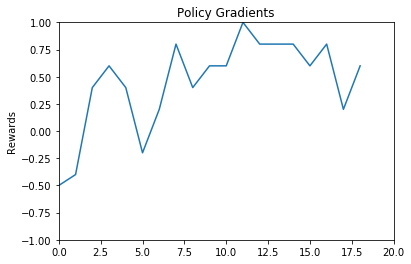

In [20]:
import matplotlib.pyplot as plt
global lis
plt.axis([0, 20, -1, 1])
plt.plot(lis)
plt.ylabel('Rewards')
plt.title("Policy Gradients")
plt.show()

In [16]:
print(lis)

[-0.5, -0.4, 0.4, 0.6, 0.4, -0.2, 0.2, 0.8, 0.4, 0.6, 0.6, 1.0, 0.8, 0.8, 0.8, 0.6, 0.8, 0.2, 0.6]


In [25]:
sum=0
for i in range(0,len(lis),1):
    sum+=lis[i]
print(sum/len(lis))

0.4473684210526316
